# Google Play Store Dataset EDA
In this project we will analyse the google play store dataset available on kaggle. The data was collected in August 2018, there are approximately 10,000 entries in this dataset. The dataset can be found here: https://www.kaggle.com/datasets/lava18/google-play-store-apps. The objective of the project is to analyse the effect of other factors like price and app category on rating and installs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from my_colors import *
import plotly.express as px

In [2]:
df = pd.read_csv('googleplaystore.csv')

# Data Preparation and Cleaning

In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Delete inaccurate data
While going through the dataset I realized that the row with index no 10472 has errors so first we will delete this row.

In [4]:
df.iloc[10472,:]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [5]:
df.drop(index=[10472], inplace=True)

We will also delete the "Current Ver" and "Android Ver" columns, which we will not be using for our analysis.

In [6]:
df.drop(columns=['Current Ver', 'Android Ver'], inplace=True)

## Delete the Duplicate data

In [7]:
df.drop_duplicates(inplace=True)

We will check for duplicate app names, since there can data with same app name but different data values. 

In [8]:
df['App'].shape

(10357,)

In [9]:
#print the number of unique values
len(df['App'].unique())

9659

The difference in the values reveals that there are data entries with same app names. We will go through the said data and look for the variations.

In [10]:
#create a list containing the names of the apps which appear more than once in the dataset
Duplicate_apps_list = df['App'].value_counts()[df['App'].value_counts()>1].index

df[df['App'] == Duplicate_apps_list[0]]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
1653,ROBLOX,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
1701,ROBLOX,GAME,4.5,4447346,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
1748,ROBLOX,GAME,4.5,4448791,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
1841,ROBLOX,GAME,4.5,4449882,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
1870,ROBLOX,GAME,4.5,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
2016,ROBLOX,FAMILY,4.5,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
2088,ROBLOX,FAMILY,4.5,4450855,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
2206,ROBLOX,FAMILY,4.5,4450890,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"
4527,ROBLOX,FAMILY,4.5,4443407,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018"


Since the only difference is in the number of reviews, we will keep the entry with highest reviews and delete others. 

In [11]:
#Run a for loop to delete the duplicate rows 
for i in range(len(Duplicate_apps_list)):
    #create a list of indecies to be deleted
    List = list(df[df['App'] == Duplicate_apps_list[i]].sort_values(by='Reviews').index[:-1])
    df.drop(index=List, inplace=True)


To ensure that the duplicate data has been deleted, we will check unique values again. 

In [12]:
df['App'].shape

(9659,)

The number of rows matches the unique value, now there are no duplicate apps.

## Data Preparation
For the data preparation process we will do the follwing things:
- Handling the null values in Rating column.
- Creating a new category column indicating whether the app is rated or not.
- Removing the '+' from the values Installs column.
- Changing the datatype of the Reviews column from object to int64.
- Transform the size values in common units.
- Remove the '$' sign from Price column.
- Creating bins for Size and Price columns.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9659 non-null   object 
 1   Category        9659 non-null   object 
 2   Rating          8196 non-null   float64
 3   Reviews         9659 non-null   object 
 4   Size            9659 non-null   object 
 5   Installs        9659 non-null   object 
 6   Type            9658 non-null   object 
 7   Price           9659 non-null   object 
 8   Content Rating  9659 non-null   object 
 9   Genres          9659 non-null   object 
 10  Last Updated    9659 non-null   object 
dtypes: float64(1), object(10)
memory usage: 905.5+ KB


There are 11 columns and 9659 rows. There are various columns which have object datatype, which can be transformed to integer or float datatype after some data cleaning.

In [14]:
df.shape

(9659, 11)

We will first check for the null values.

In [15]:
#gives columns with count of total null values.
df.isnull().sum()

App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
dtype: int64

The null values in rating represent no ratings, for the data analysis we will replace these null values with 0. We will also create a new category column indicating whether the app was rated.

In [16]:
df.Rating.unique()

array([4.1, 4.7, 4.5, 4.3, 4.4, 3.8, 4.2, 4.6, 3.2, 4. , 4.8, 3.9, 4.9,
       3.6, 3.7, nan, 3.3, 3.4, 3.5, 3.1, 5. , 2.6, 3. , 2.5, 2.8, 2.7,
       1. , 1.9, 2.9, 2.3, 2.2, 1.7, 2. , 1.8, 2.4, 1.6, 2.1, 1.4, 1.5,
       1.2])

In [17]:
# we will create a copy of dataset to make changes and keep the original as it is.
clean_df = df.copy()

In [18]:
#fill the null values with 0
clean_df['Rating'] = clean_df['Rating'].fillna(0)

In [19]:
#Create a new column
clean_df['Rating Category'] = clean_df['Rating'].apply(lambda x: False if x == 0 else True )

In [20]:
clean_df[clean_df['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Rating Category
9148,Command & Conquer: Rivals,FAMILY,0.0,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",False


Since the price is 0, the Type should be free.

In [21]:
clean_df.iloc[9148,6] = 'Free'

In [22]:
#print all unique values in Installs column
clean_df['Installs'].unique()

array(['10,000+', '5,000,000+', '50,000,000+', '100,000+', '50,000+',
       '1,000,000+', '10,000,000+', '5,000+', '500,000+',
       '1,000,000,000+', '100,000,000+', '1,000+', '500,000,000+', '50+',
       '100+', '500+', '10+', '1+', '5+', '0+', '0'], dtype=object)

We will remove the '+' sign from the Installs values, and replace the values as follows.

In [23]:
#A dictionary to be used in transforming the values of Installs column
cases={ '10,000+': '10K', '500,000+': '500K', '5,000,000+': '5M', '50,000,000+': '50M', '100,000+': '100K',
       '50,000+':'50K', '1,000,000+':'1M', '10,000,000+':'10M', '5,000+':'5K', '100,000,000+':'100M',
       '1,000,000,000+':'1B', '1,000+':'1K', '500,000,000+':'500M', '50+':'50', '100+':'100', '500+':'500',
       '10+':'10', '1+':'1', '5+':'5', '0+':'0', '0':'0'}
    

In [24]:
# A list containing the unique values of Installs column in order
Installs_order = [ '1', '5', '10', '50', '100', '500', 
        '1K', '5K', '10K', '50K', '100K', '500K', '1M', 
        '5M', '10M', '50M', '100M', '500M',  '1B'
         ]

In [25]:
# replace the valuse using the cases dictionary
clean_df['Installs'] = clean_df['Installs'].apply(lambda x: cases[x])

In [26]:
#Print the unique values in Size column
clean_df['Size'].unique()

array(['19M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M', '28M',
       '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M', '31M',
       '14M', '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M',
       '11M', 'Varies with device', '9.4M', '15M', '10M', '1.2M', '24M',
       '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k', '3.6M',
       '5.7M', '8.6M', '2.4M', '27M', '2.5M', '7.0M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '8.4M', '118k', '44M', '695k', '1.6M',
       '6.2M

The size of apps in MB and KB, we will transform all the values in MB. 

In [27]:
#define a function to convert all app sizes into MB
def convert(size):
    if size[-1] == 'k':
        return float(size[:-1])*0.001
    elif size[-1] == 'M':
        return float(size[:-1])
    else:
        return np.NaN

The 'varies with device' is replaced with null values

In [28]:
clean_df['Size'] = clean_df['Size'].apply(convert)

In [29]:
clean_df['Size'].isnull().sum()

1227

We will use the transform method of groupby objects to fill the nan values.

In [30]:
clean_df['Size'] = clean_df['Size'].fillna(clean_df.groupby('Category')['Size'].transform('mean'))

The following code converts the dtype of 'Reviews' column from object to int64. 

In [31]:
clean_df['Reviews'] = clean_df['Reviews'].astype('int64')

We need to remove dollar sign from the price column.

In [32]:
# Function to apply on Price column
def Apply_Price(s):
    if s == '0':
        return 0
    else:
        return float(s[1:])

In [33]:
clean_df['Price'] = clean_df['Price'].apply(Apply_Price)

We create a custom function to create bins from numerical data, the function takes min value, max value, bin width or no of bins as input.

In [34]:
class Invalid_Input(Exception):
    "Raised when niether bin width nor number of bins are provided"
    pass

def create_bins(min : float, max : float, bin_w=None, no_of_bins=None, correction=1, decimal=3):
    list_of_bins = []
    try : 
        if bin_w is None and no_of_bins is None:
            raise Invalid_Input
    except Invalid_Input:
        print('Exception Occured: Invalid Inputs')
    
    if bin_w is not None and no_of_bins is not None:
        print('Entered both bin width and no of bins, hence only bin width will be considered')
        no_of_bins = None

    if bin_w is None:
        bin_w = (max-min)/no_of_bins

    if no_of_bins is None:
        no_of_bins = int((max-min)/bin_w) + 1

    for i in range(no_of_bins):
        start = min + i*bin_w 
        end = min + (i+1)*bin_w - correction
        if correction<1:
            start = round(start, decimal)
            end = round(end, decimal)
        list_of_bins.append(str(start)+'-'+str(end))
    return list_of_bins

We create bins of width 2 for size of apps column.

In [35]:
list_of_size_bins = create_bins(0, 100, bin_w=2)
clean_df['Size bins'] = clean_df['Size'].apply(lambda x: list_of_size_bins[int(x//2)])

We create bins of size 0.2 for Price column of data.

In [36]:
list_of_price_bins = create_bins(0, 400, bin_w=0.2, correction=0.1)
clean_df['Price bins'] = clean_df['Price'].apply(lambda x: list_of_price_bins[int(x//0.2)])

In [37]:
# The following code creates a list of ordered bins
l = list(clean_df[clean_df['Rating Category'] & (clean_df['Type'] == 'Paid') & (clean_df['Price'] <= 50)].groupby('Price bins')['Rating'].mean().index)
price_bins_order = l[:6] + l[18:20] + l[22:26] +l[29:]+ l[6:18]+ l[20:22]+ l[26:29]

We will also convert the 'Last Updated' column to proper datetime datatype.

In [38]:
datetime.strptime('January 7, 2018', "%B %d, %Y" )

datetime.datetime(2018, 1, 7, 0, 0)

In [39]:
clean_df['Last Updated'] = pd.to_datetime(clean_df['Last Updated'], dayfirst=True, format= "%B %d, %Y")

# EDA

## Rating

In [40]:
clean_df[clean_df['Rating Category']]['Rating'].describe()

count    8196.000000
mean        4.173084
std         0.536522
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Text(0.5, 1.0, 'Distribution of Rating')

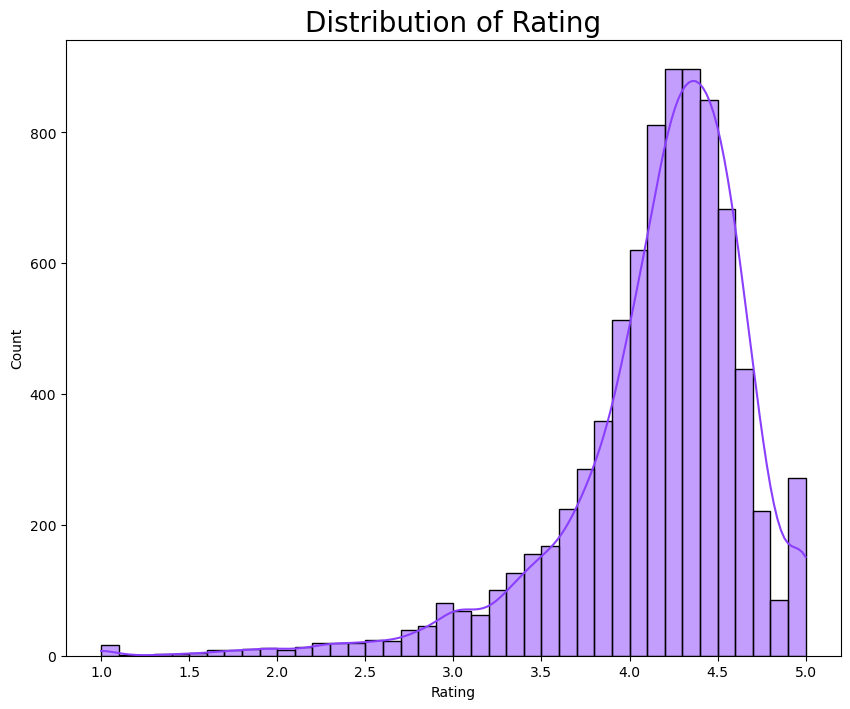

In [41]:
plt.figure(figsize= (10,8))
ax = sns.histplot(data = clean_df[clean_df['Rating Category']]['Rating'], kde=True, color=Light_Categorical_Colors[0], binwidth=0.1)
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
plt.title("Distribution of Rating", size=20)

### Observation
The average rating of apps is 4.2 which is pretty high. More than 75% apps have greater than or equal to 4.0 rating, implying that a huge number of apps have high rating.

## Categories

In [42]:
#Print the unique Categories
clean_df["Category"].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [43]:
# create a group object, grouped by category. 
group_obj = clean_df.groupby('Category')

Text(0.5, 1.0, 'Categorywise apps distribution')

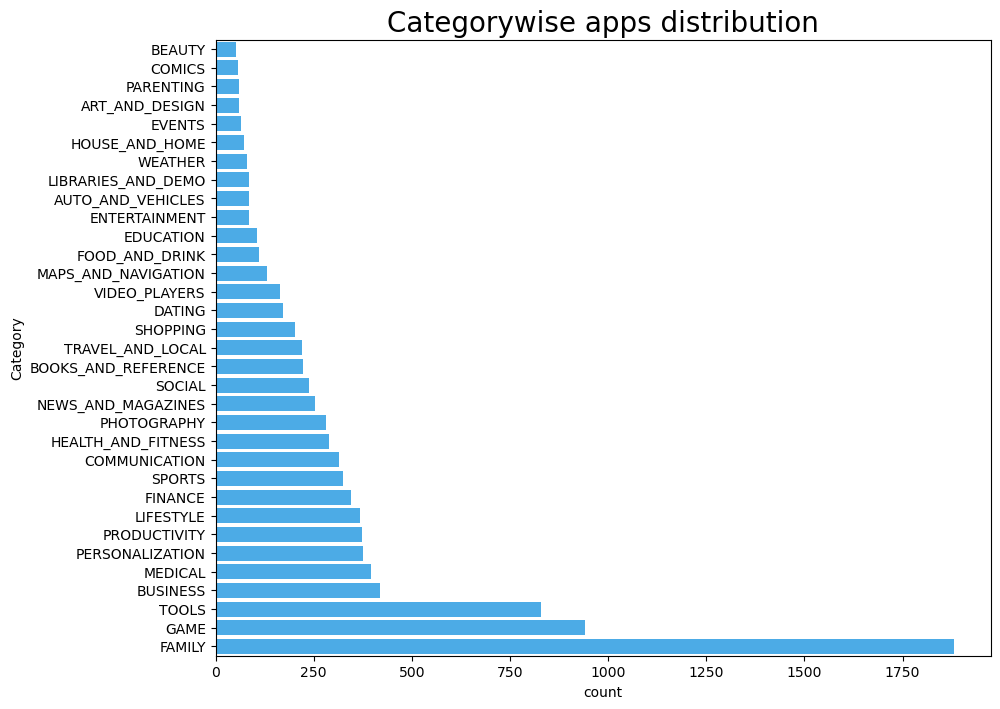

In [44]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data=clean_df, y='Category', order=group_obj["Category"].count().sort_values().index , color=Light_Categorical_Colors[1])
plt.title("Categorywise apps distribution", size=20)

In [45]:
group_obj['Category'].value_counts()

Category             Category           
ART_AND_DESIGN       ART_AND_DESIGN           61
AUTO_AND_VEHICLES    AUTO_AND_VEHICLES        85
BEAUTY               BEAUTY                   53
BOOKS_AND_REFERENCE  BOOKS_AND_REFERENCE     222
BUSINESS             BUSINESS                420
COMICS               COMICS                   56
COMMUNICATION        COMMUNICATION           315
DATING               DATING                  171
EDUCATION            EDUCATION               106
ENTERTAINMENT        ENTERTAINMENT            86
EVENTS               EVENTS                   64
FAMILY               FAMILY                 1880
FINANCE              FINANCE                 345
FOOD_AND_DRINK       FOOD_AND_DRINK          112
GAME                 GAME                    942
HEALTH_AND_FITNESS   HEALTH_AND_FITNESS      288
HOUSE_AND_HOME       HOUSE_AND_HOME           73
LIBRARIES_AND_DEMO   LIBRARIES_AND_DEMO       84
LIFESTYLE            LIFESTYLE               369
MAPS_AND_NAVIGATION  MAPS_AN

### Observation
The Family category has highest number of apps. Tools, Gaming and Family are the top 3 categories with large number of apps. 

In [46]:
#A group object, grouped by category containing only rated apps
group_obj_rated = clean_df[clean_df['Rating Category']].groupby('Category')

In [47]:
# average rating of each category
group_obj_rated['Rating'].mean().sort_values(ascending=False)

Category
EVENTS                 4.435556
ART_AND_DESIGN         4.359322
EDUCATION              4.353333
BOOKS_AND_REFERENCE    4.344970
PERSONALIZATION        4.332215
PARENTING              4.300000
BEAUTY                 4.278571
SOCIAL                 4.247291
GAME                   4.243352
WEATHER                4.243056
HEALTH_AND_FITNESS     4.243033
SHOPPING               4.230556
SPORTS                 4.216154
AUTO_AND_VEHICLES      4.190411
FAMILY                 4.184230
PRODUCTIVITY           4.183389
COMICS                 4.181481
LIBRARIES_AND_DEMO     4.178125
FOOD_AND_DRINK         4.171277
MEDICAL                4.166552
PHOTOGRAPHY            4.157414
HOUSE_AND_HOME         4.140984
ENTERTAINMENT          4.129070
NEWS_AND_MAGAZINES     4.121569
COMMUNICATION          4.121484
FINANCE                4.115563
BUSINESS               4.098479
LIFESTYLE              4.093355
TRAVEL_AND_LOCAL       4.069519
VIDEO_PLAYERS          4.044966
TOOLS                  4.039917

Text(0.5, 1.0, 'Category wise average rating')

<Figure size 1000x800 with 0 Axes>

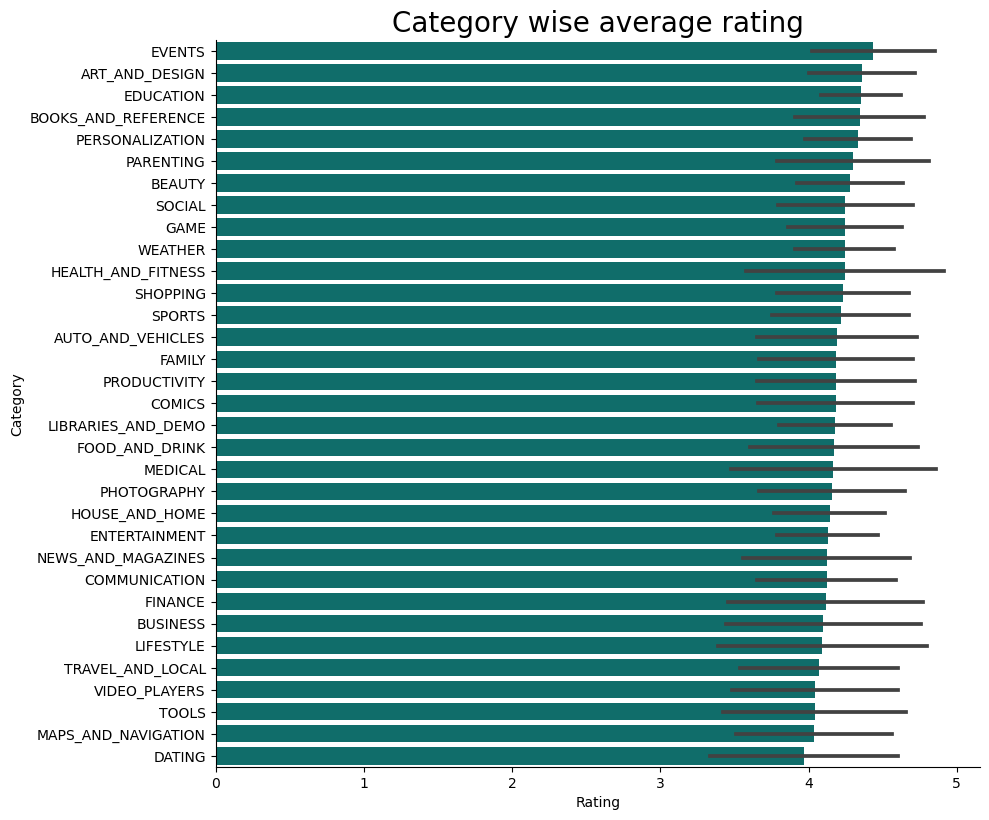

In [48]:
plt.figure(figsize=(10,8))
sns.catplot(data=clean_df[clean_df['Rating Category']], y='Category', x='Rating', kind='bar', height=8, aspect=1.25, ci='sd', color=Light_Categorical_Colors[2],
            order=group_obj_rated['Rating'].mean().sort_values(ascending=False).index)
plt.title('Category wise average rating', size=20)

### Observation
Almost all the categories have greater than 4 average rating. Further, the type of category does not seems to have any significant effect on the average rating.

## Installs

Text(0.5, 1.0, 'Countplot for Installs')

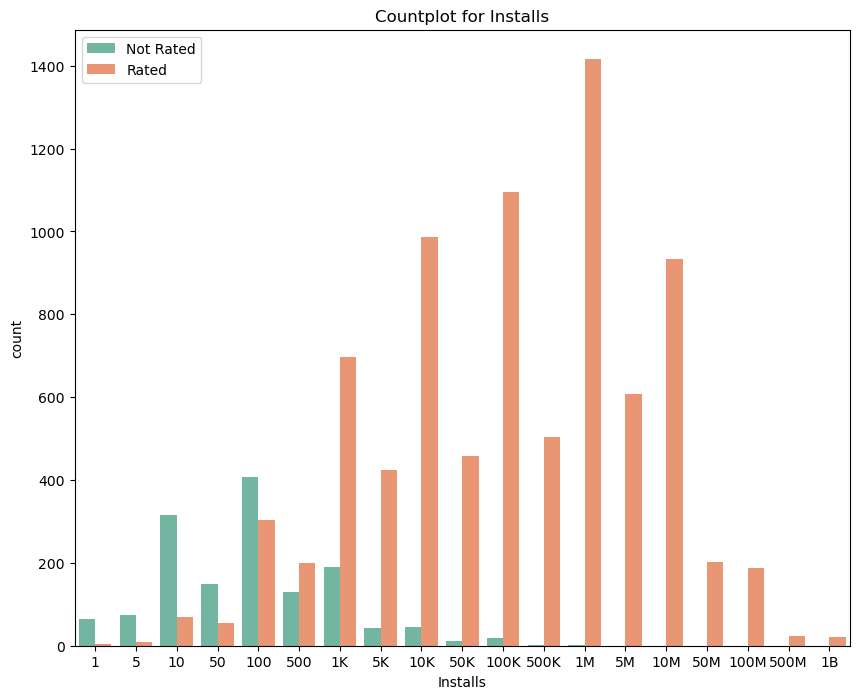

In [49]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data=clean_df, x='Installs', hue='Rating Category', 
              order= Installs_order, palette='Set2')
ax.legend(labels=['Not Rated', 'Rated'])
plt.title("Countplot for Installs")

In [50]:
clean_df[(~clean_df['Rating Category']) & (clean_df['Installs'].isin(['10K','50K', '100K', '500K', '1M']))]['Installs'].value_counts()

10K     44
100K    18
50K     12
1M       2
500K     1
Name: Installs, dtype: int64

Note that for apps with less than 10K installs there are significant number of apps which are not rated, which is expected and is probably because the apps are new. The surprising fact is that there are more 20 apps with 50K and 100K installs but no rating. 

Text(0.5, 1.0, 'Average Ratings VS Installs')

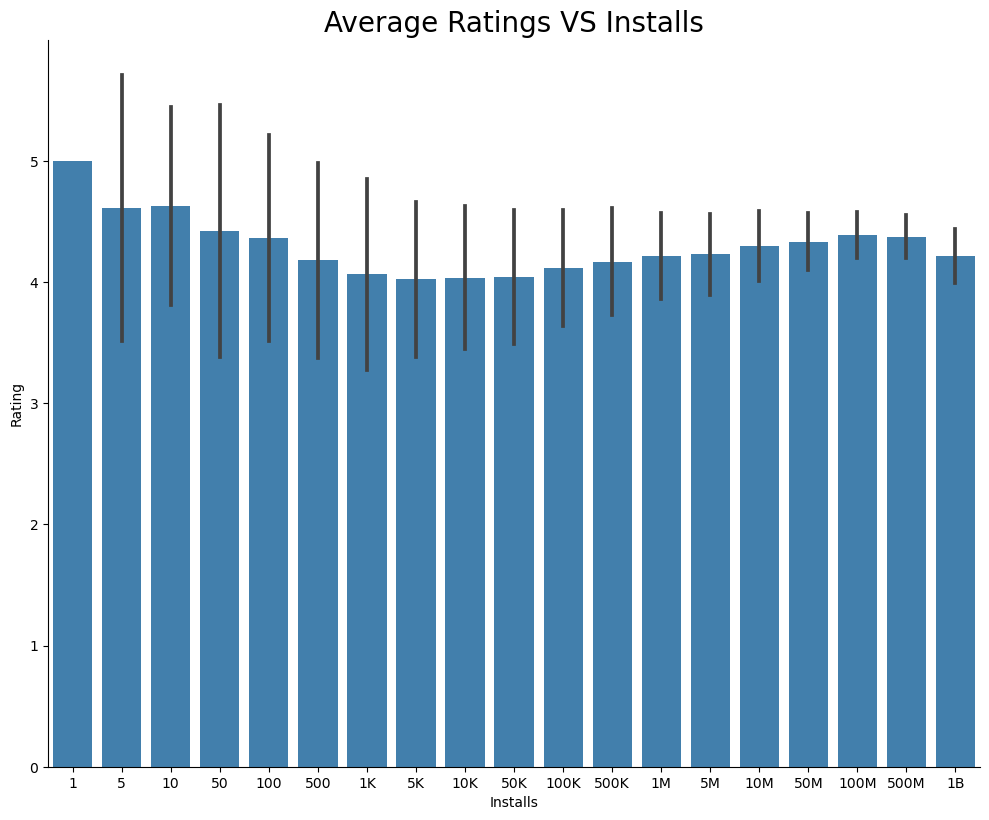

In [51]:
sns.catplot(data=clean_df[clean_df['Rating Category']], x='Installs', y='Rating', kind='bar', height= 8, aspect=1.25, ci='sd', color=Tab_5[0], order=Installs_order)
plt.title("Average Ratings VS Installs", size=20)

Text(0.5, 1.0, 'Average Ratings VS Installs')

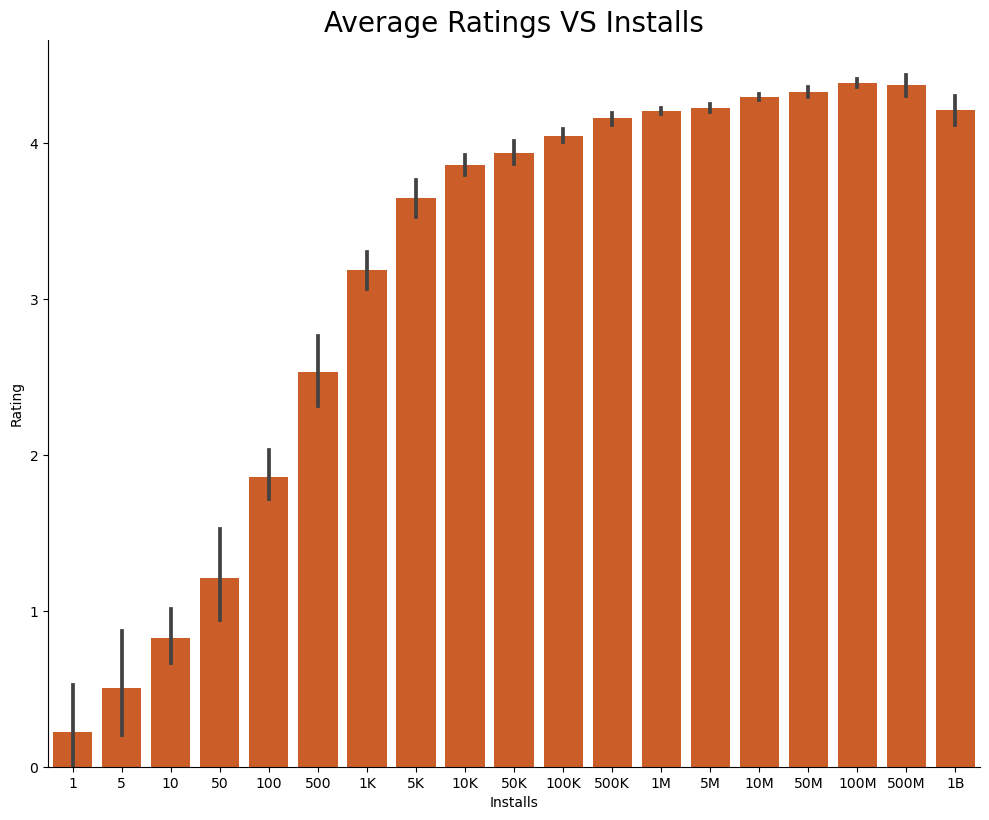

In [52]:
sns.catplot(data=clean_df, x='Installs', y='Rating', kind='bar', height= 8, aspect=1.25, color=Tab_5[1], order=Installs_order)
plt.title("Average Ratings VS Installs", size=20)

### Observation
The plots above suggests that rating and installs are related. If we also include apps which have zero rating(not rated) then we see a strong relation between ratings and installs which is expected.

## Reviews

In [53]:
clean_df[~clean_df['Rating Category']]['Reviews'].value_counts().sort_index()

0       593
1       205
2       131
3        94
4        63
       ... 
1317      1
1330      1
2221      1
2536      1
3248      1
Name: Reviews, Length: 100, dtype: int64

There are apps with more 1000 reviews but no rating.

<AxesSubplot:xlabel='Reviews', ylabel='Density'>

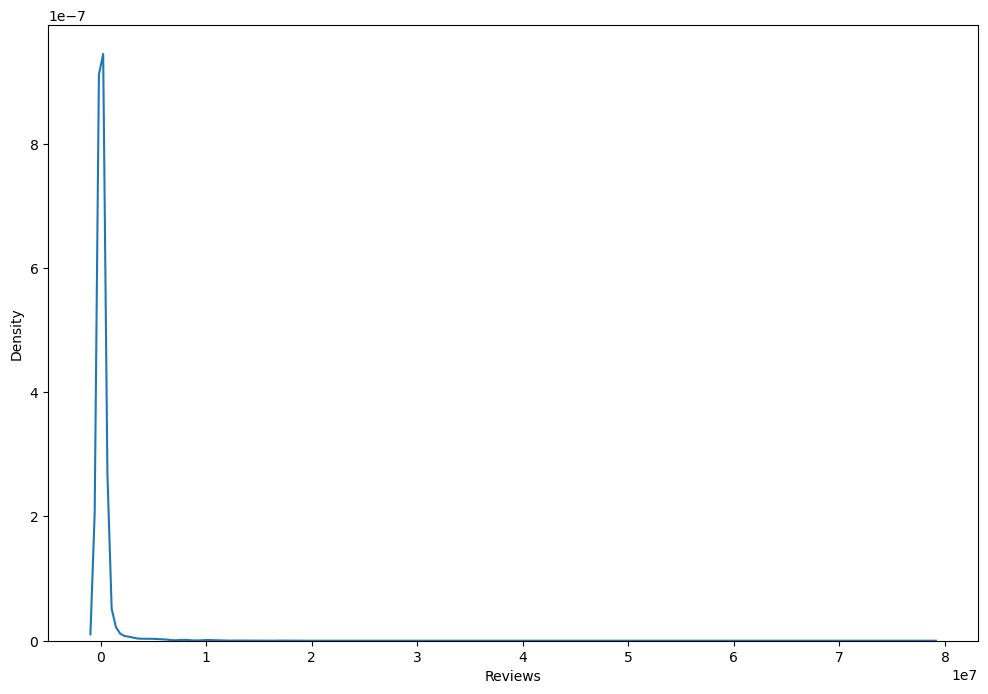

In [54]:
plt.figure(figsize=(12,8))
sns.kdeplot(data=clean_df[clean_df['Rating Category']], x= 'Reviews')

In [55]:
Reviews_1M = clean_df[clean_df['Rating Category'] & (clean_df['Reviews'] > 1000000)]

<AxesSubplot:xlabel='Rating'>

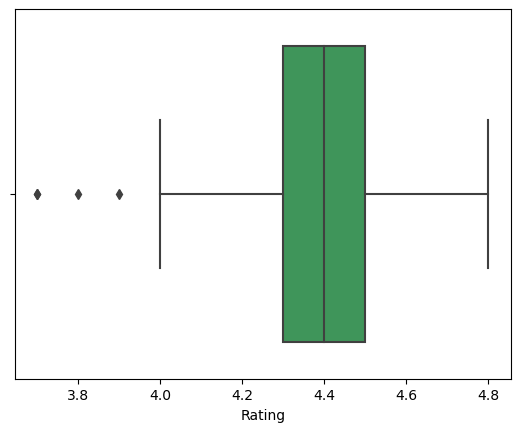

In [56]:
sns.boxplot(data=Reviews_1M, x='Rating', color=Tab_5[2])

Most of the apps with more than 1M reviews have very high rating. 

Text(0.5, 1.0, 'Reviews Distribution')

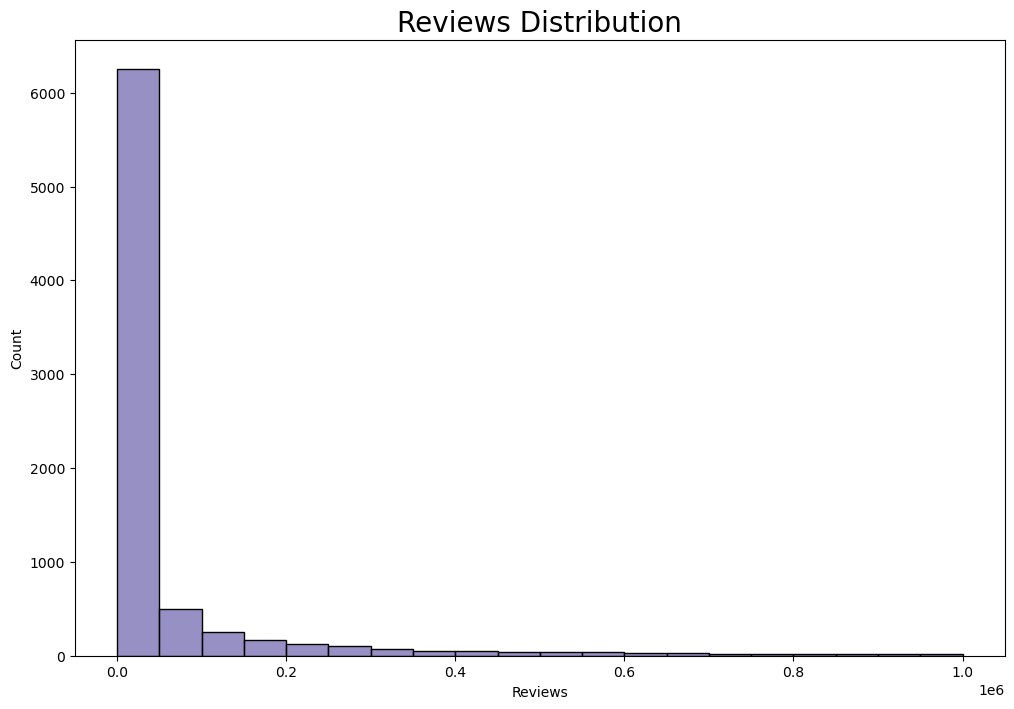

In [57]:
plt.figure(figsize=(12,8))
sns.histplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Reviews'] < 1000000)], x= 'Reviews', binwidth=50000, color=Tab_5[3])
plt.title('Reviews Distribution', size=20)

Text(0.5, 1.0, 'Reviews VS Rating')

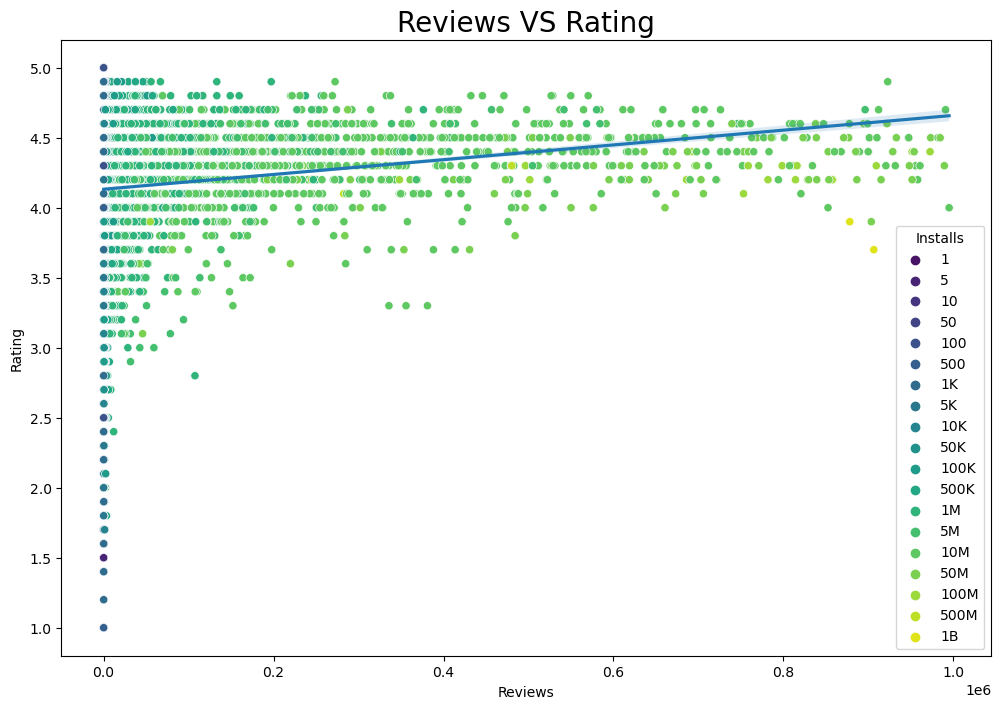

In [58]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Reviews'] < 1000000)], x= 'Reviews', y= 'Rating', hue='Installs', hue_order=Installs_order, palette="viridis")
sns.regplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Reviews'] < 1000000)], x= 'Reviews', y= 'Rating', scatter=False, ax=ax)
plt.title('Reviews VS Rating', size=20)

### Observation
There is a positive linear relation between rating and number of reviews. Also higher number of reviews implies higher number of installs as expected.

## Size

In [59]:
clean_df['Size'].describe()

count    9659.000000
mean       20.153581
std        20.612052
min         0.008500
25%         5.300000
50%        13.134701
75%        27.000000
max       100.000000
Name: Size, dtype: float64

Text(0.5, 1.0, 'Distribution of Size')

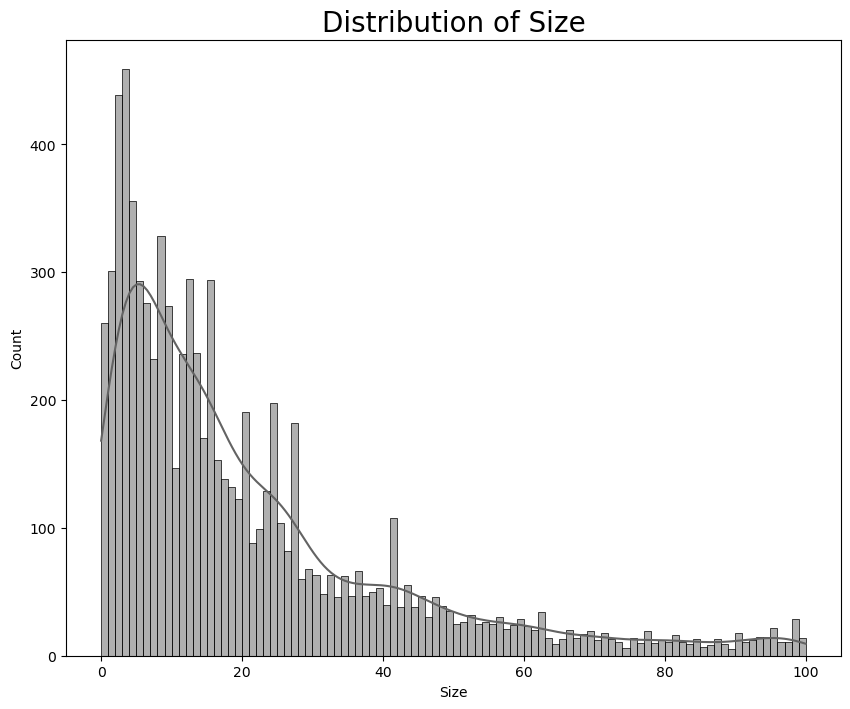

In [60]:
plt.figure(figsize= (10,8))
ax = sns.histplot(data = clean_df[clean_df['Rating Category']]['Size'], kde=True, color=Tab_5[4], binwidth=1)
plt.title("Distribution of Size", size=20)

Text(0.5, 1.0, 'Distribution of Size across various Categories')

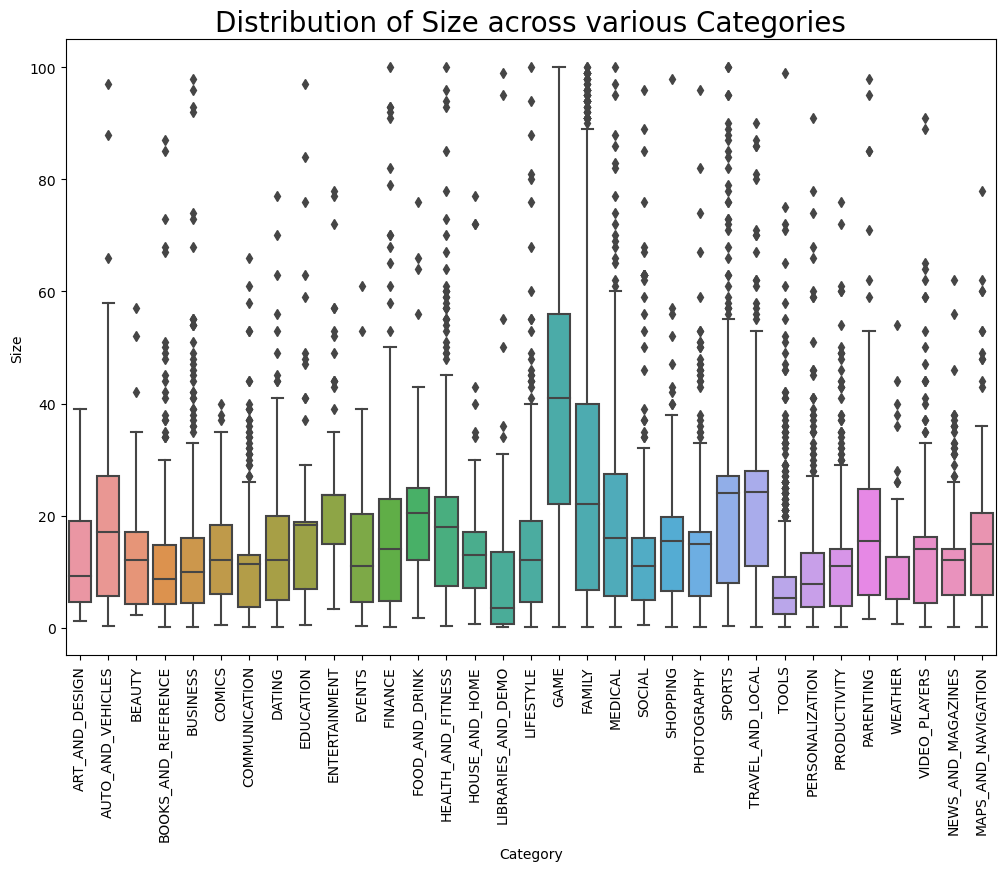

In [61]:
plt.figure(figsize=(12,8))
sns.boxplot(data=clean_df, x='Category', y='Size')
plt.xticks(rotation=90)
plt.title('Distribution of Size across various Categories', size=20)

We can see how GAME and FAMILY category apps are nicely distributed in size.

Text(0.5, 1.0, 'Size VS Rating Scatter Plot')

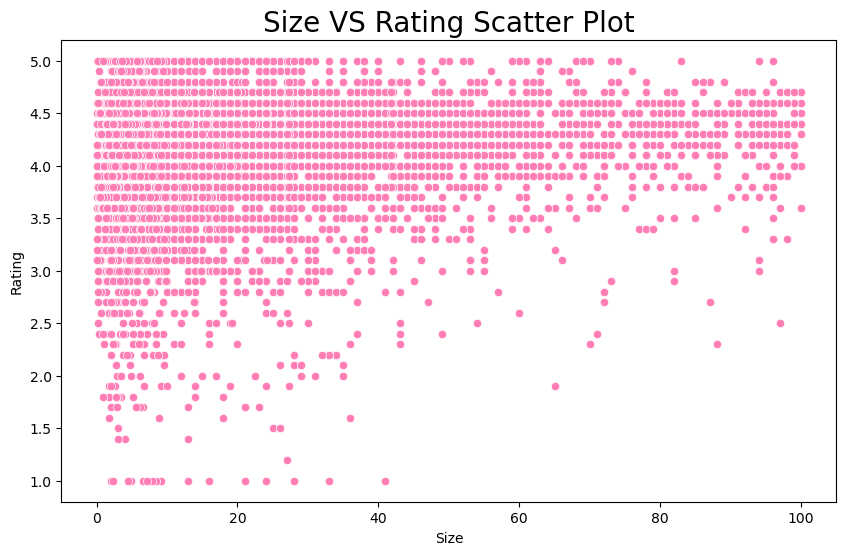

In [62]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=clean_df[clean_df['Rating Category']], x='Size', y='Rating', color=Light_Categorical_Colors[3])
plt.title('Size VS Rating Scatter Plot', size=20)

Text(0.5, 1.0, 'Size VS Rating Scatter Plot (GAME)')

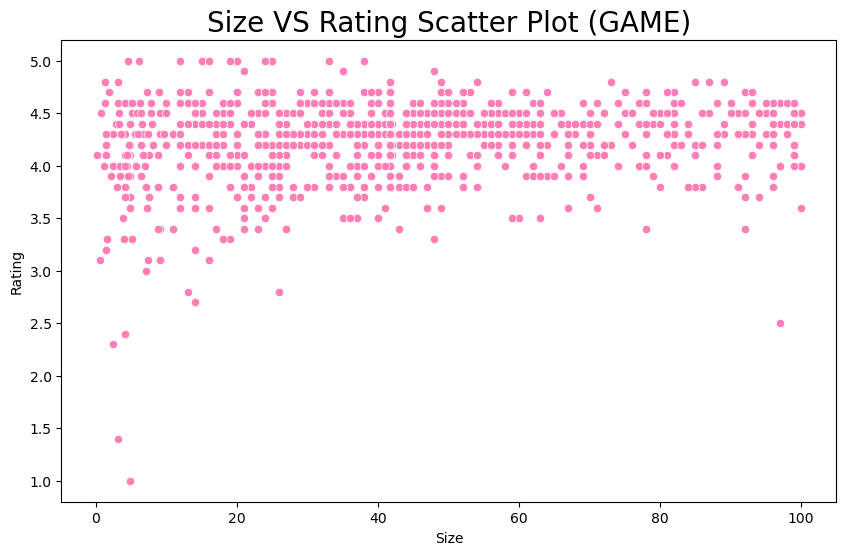

In [63]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Category'] == 'GAME')], x='Size', y='Rating', color=Light_Categorical_Colors[3])
plt.title('Size VS Rating Scatter Plot (GAME)', size=20)

Text(0.5, 1.0, 'Size VS Rating Scatter Plot (FAMILY)')

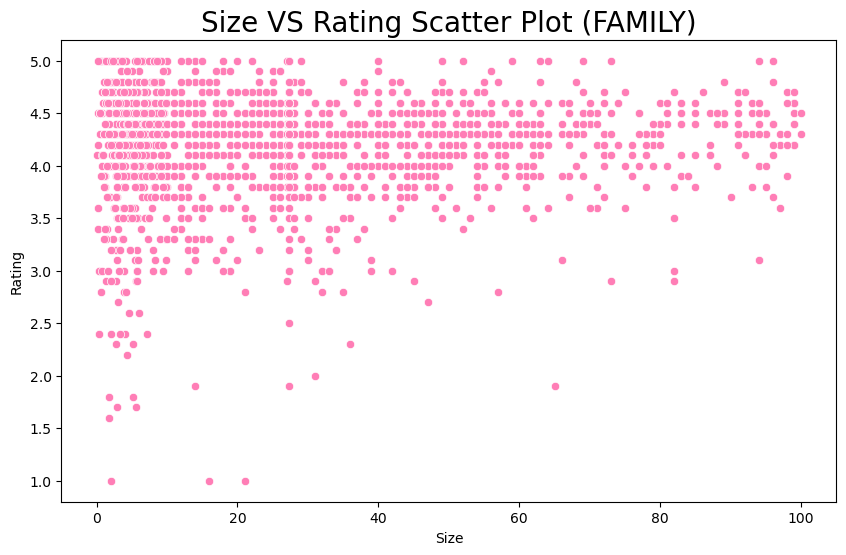

In [64]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Category'] == 'FAMILY')], x='Size', y='Rating', color=Light_Categorical_Colors[3])
plt.title('Size VS Rating Scatter Plot (FAMILY)', size=20)

Not much can be concluded from the scatter plot. Hence we will create for size and then look at the avg rating.

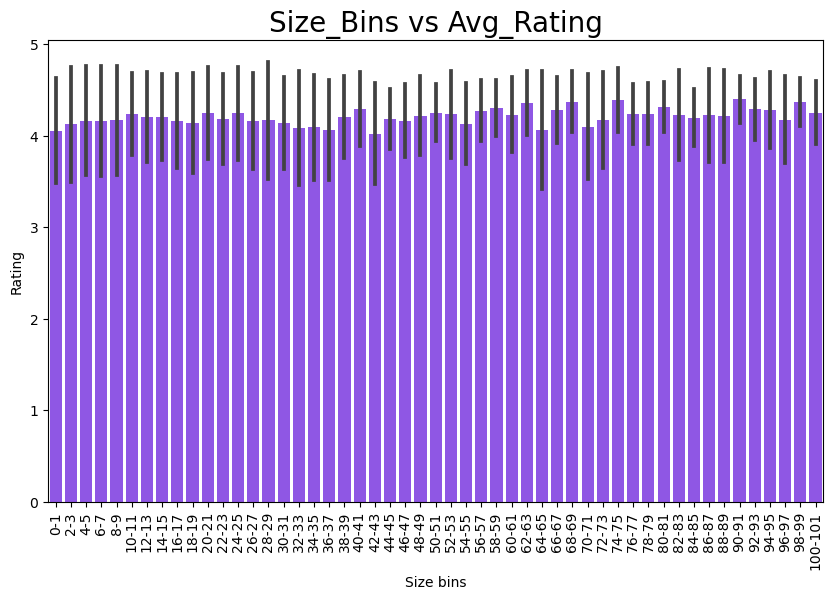

In [65]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=clean_df[clean_df['Rating Category']], x='Size bins', y='Rating', color=Light_Categorical_Colors[0], order=list_of_size_bins, ci='sd')
plt.title('Size_Bins vs Avg_Rating', size=20)
plt.xticks(rotation=90)
plt.show()

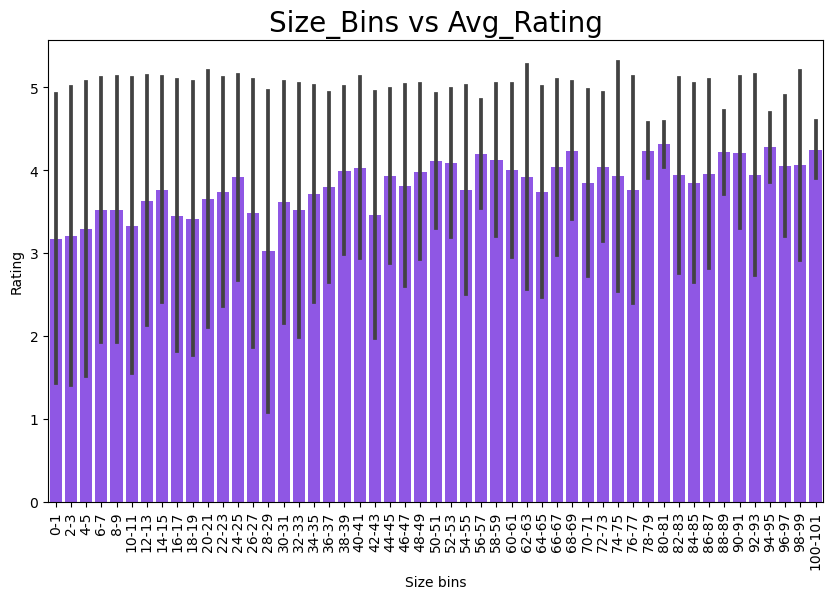

In [66]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=clean_df, x='Size bins', y='Rating', color=Light_Categorical_Colors[0], order=list_of_size_bins, ci='sd')
plt.title('Size_Bins vs Avg_Rating', size=20)
plt.xticks(rotation=90)
plt.show()

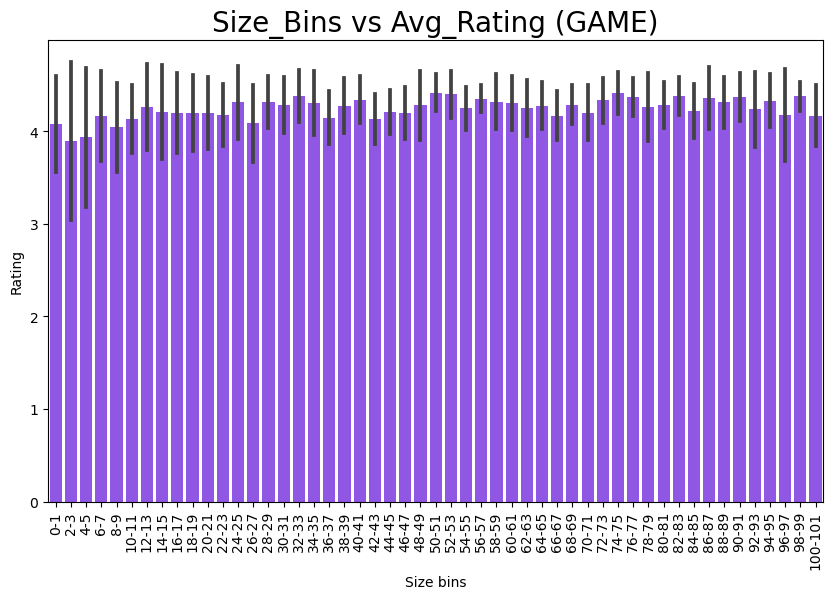

In [67]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Category'] == 'GAME')], x='Size bins', y='Rating', color=Light_Categorical_Colors[0], order=list_of_size_bins, ci='sd')
plt.title('Size_Bins vs Avg_Rating (GAME)', size=20)
plt.xticks(rotation=90)
plt.show()

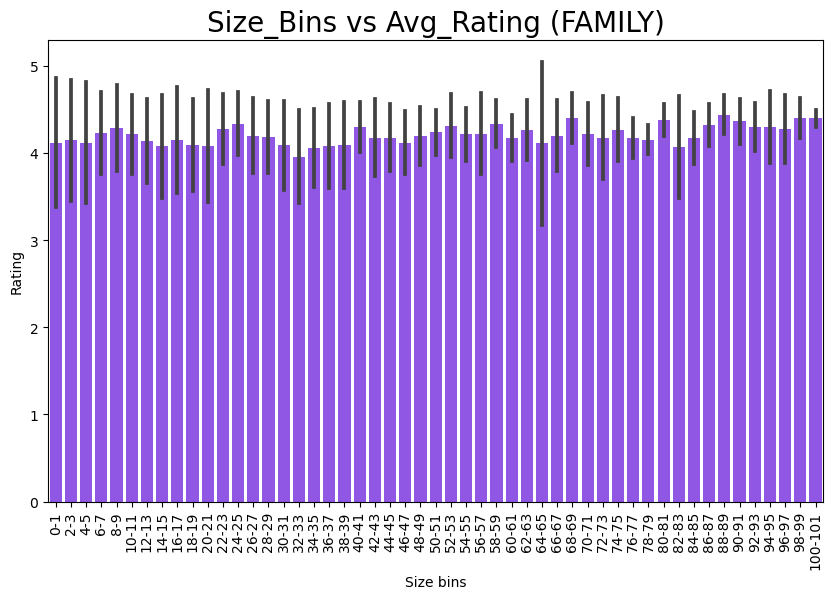

In [68]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Category'] == 'FAMILY')], x='Size bins', y='Rating', color=Light_Categorical_Colors[0], order=list_of_size_bins, ci='sd')
plt.title('Size_Bins vs Avg_Rating (FAMILY)', size=20)
plt.xticks(rotation=90)
plt.show()

### Observation
It seems there is no significant effect of size on average rating. A lot of low sized apps seems to be not rated. Even in specific categories size does not seem to affect ratings.

<AxesSubplot:xlabel='Installs', ylabel='Size'>

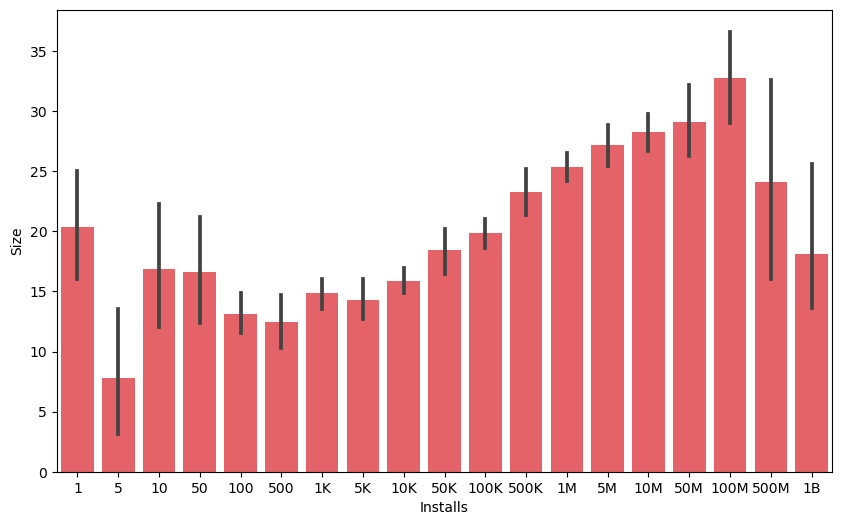

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(data=clean_df[clean_df['Rating Category']], x='Installs', y='Size', order=Installs_order, color=Light_Categorical_Colors[4])

### Observation
The average size is low for low installs.

## Price

In [70]:
clean_df['Price'].unique()

array([  0.  ,   4.99,   3.99,   6.99,   1.49,   2.99,   7.99,   3.49,
         1.99,   5.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,
        11.99,  79.99,  16.99,  14.99,   1.  ,  29.99,  12.99,   2.49,
        24.99,  10.99,   1.5 ,  19.99,  15.99,  33.99,  74.99,  39.99,
         3.95,   4.49,   1.7 ,   8.99,   2.  ,   3.88,  25.99, 399.99,
        17.99, 400.  ,   3.02,   1.76,   4.84,   4.77,   1.61,   2.5 ,
         1.59,   6.49,   1.29,   5.  ,  13.99, 299.99, 379.99,  37.99,
        18.99, 389.99,  19.9 ,   8.49,   1.75,  14.  ,   4.85,  46.99,
       109.99, 154.99,   3.08,   2.59,   4.8 ,   1.96,  19.4 ,   3.9 ,
         4.59,  15.46,   3.04,   4.29,   2.6 ,   3.28,   4.6 ,  28.99,
         2.95,   2.9 ,   1.97, 200.  ,  89.99,   2.56,  30.99,   3.61,
       394.99,   1.26,   1.2 ,   1.04])

In [71]:
clean_df['Price'].describe()

count    9659.000000
mean        1.099299
std        16.852152
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       400.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'Installs Free VS Paid')

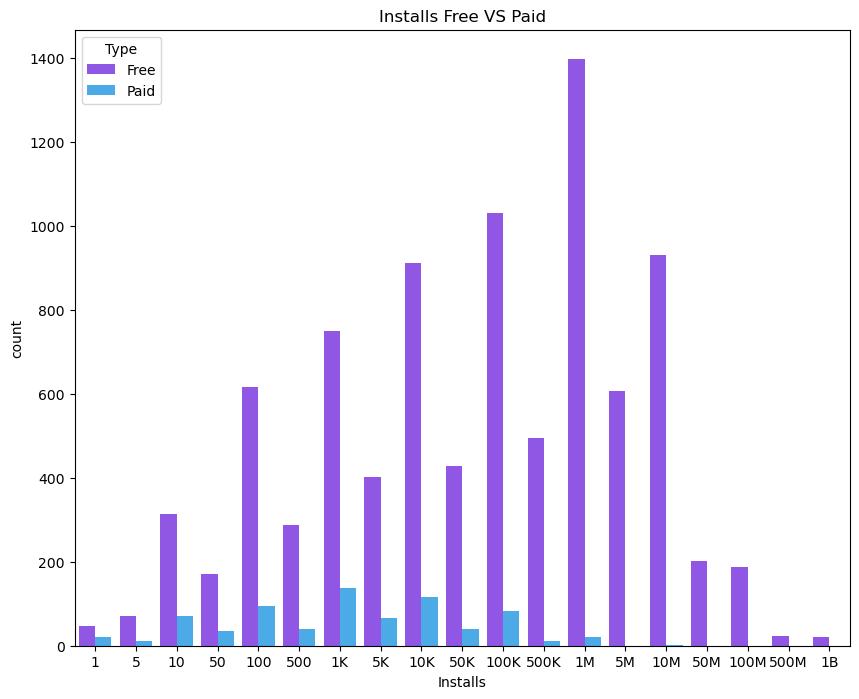

In [72]:
plt.figure(figsize=(10,8))
sns.countplot(data=clean_df, x='Installs', hue='Type', palette=Light_Categorical_Colors, order=Installs_order)
plt.title('Installs Free VS Paid')

<AxesSubplot:xlabel='count', ylabel='Category'>

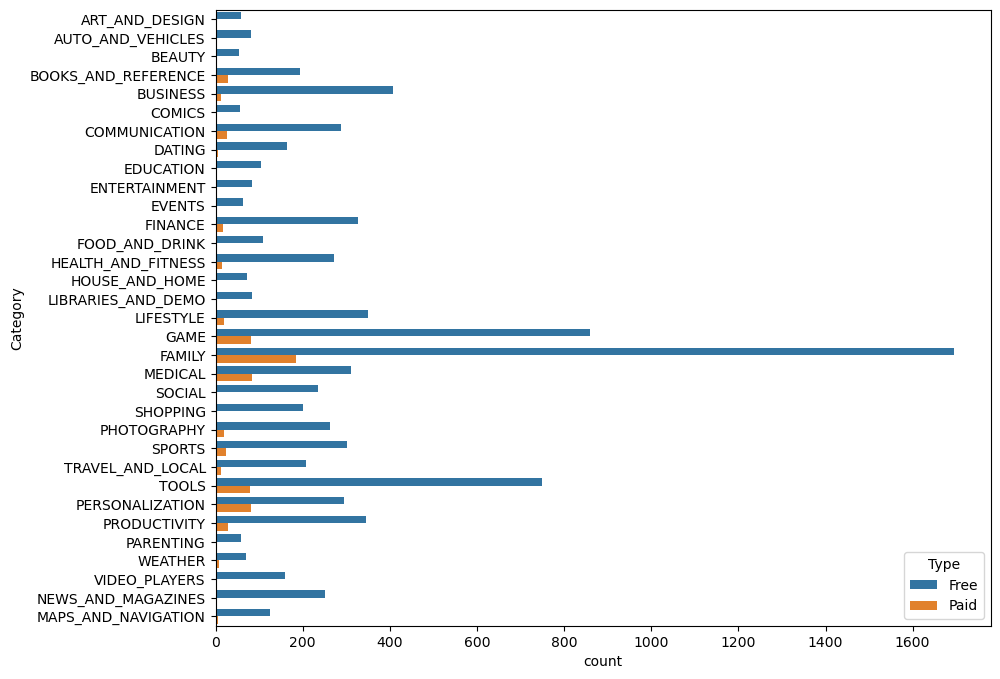

In [73]:
plt.figure(figsize=(10,8))
sns.countplot(data=clean_df, y='Category', hue='Type')

In [74]:
#List of categories with significant number of paid apps
List_of_Paid_Categories = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS', 'PERSONALIZATION']

Text(0.5, 1.0, 'Installs Free VS Paid')

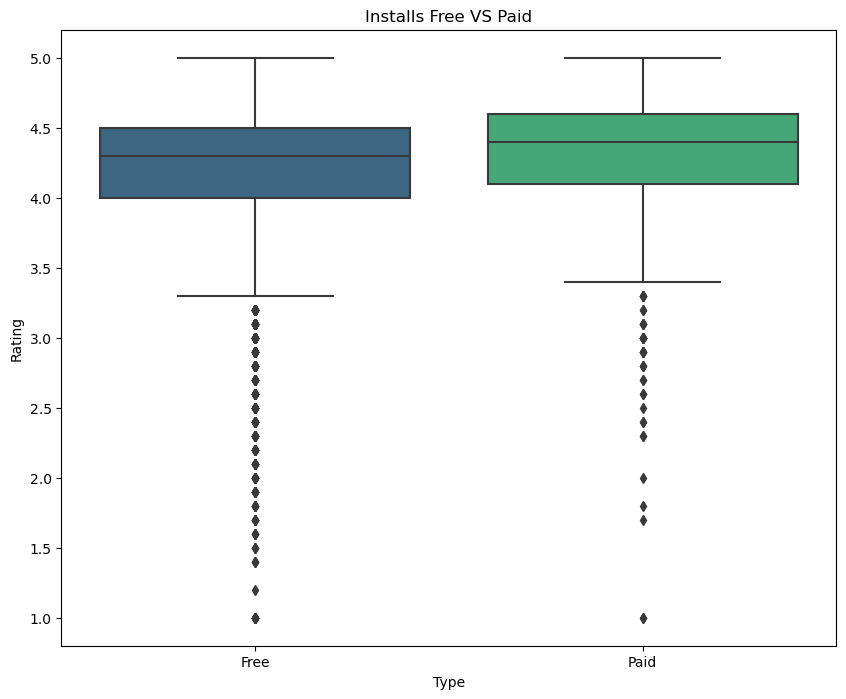

In [75]:
plt.figure(figsize=(10,8))
sns.boxplot(data=clean_df[clean_df['Rating Category']], x='Type', y='Rating', palette='viridis')
plt.title('Installs Free VS Paid')

### Observation
Free and Paid apps both have simillar distribution of rating.

In [76]:
clean_df[clean_df['Price'] > 100]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Rating Category,Size bins,Price bins
4197,most expensive app (H),FAMILY,4.3,6,1.500,100,Paid,399.99,Everyone,Entertainment,2018-07-16,True,0-1,399.8-399.9
4362,💎 I'm rich,LIFESTYLE,3.8,718,26.000,10K,Paid,399.99,Everyone,Lifestyle,2018-03-11,True,26-27,399.8-399.9
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,10K,Paid,400.00,Everyone,Lifestyle,2018-05-03,True,6-7,399.8-399.9
5351,I am rich,LIFESTYLE,3.8,3547,1.800,100K,Paid,399.99,Everyone,Lifestyle,2018-01-12,True,0-1,399.8-399.9
5354,I am Rich Plus,FAMILY,4.0,856,8.700,10K,Paid,399.99,Everyone,Entertainment,2018-05-19,True,8-9,399.8-399.9
5355,I am rich VIP,LIFESTYLE,3.8,411,2.600,10K,Paid,299.99,Everyone,Lifestyle,2018-07-21,True,2-3,299.8-299.9
5356,I Am Rich Premium,FINANCE,4.1,1867,4.700,50K,Paid,399.99,Everyone,Finance,2017-11-12,True,4-5,399.8-399.9
5357,I am extremely Rich,LIFESTYLE,2.9,41,2.900,1K,Paid,379.99,Everyone,Lifestyle,2018-07-01,True,2-3,379.8-379.9
5358,I am Rich!,FINANCE,3.8,93,22.000,1K,Paid,399.99,Everyone,Finance,2017-12-11,True,22-23,399.8-399.9
5359,I am rich(premium),FINANCE,3.5,472,0.965,5K,Paid,399.99,Everyone,Finance,2017-05-01,True,0-1,399.8-399.9


We will ignore the above apps for price analysis.

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

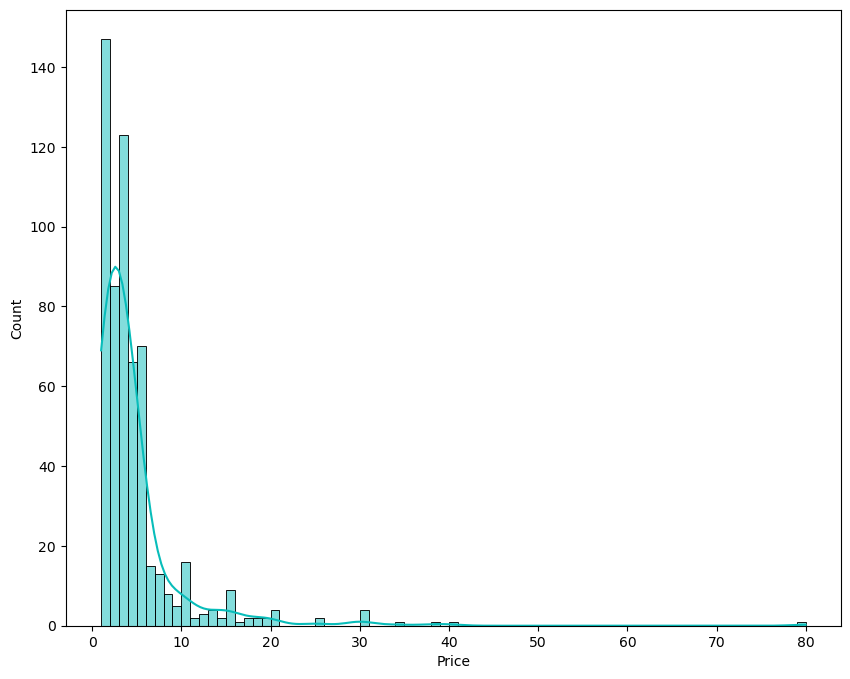

In [77]:
Paid_data = clean_df[clean_df['Rating Category'] & (clean_df['Type'] == 'Paid') & (clean_df['Price'] <= 100)]
plt.figure(figsize=(10,8))
sns.histplot(data=Paid_data, x='Price', kde=True, color=Light_Categorical_Colors[10], binwidth=1)
plt.title

Most of the apps have less than or equal to 10$ price.

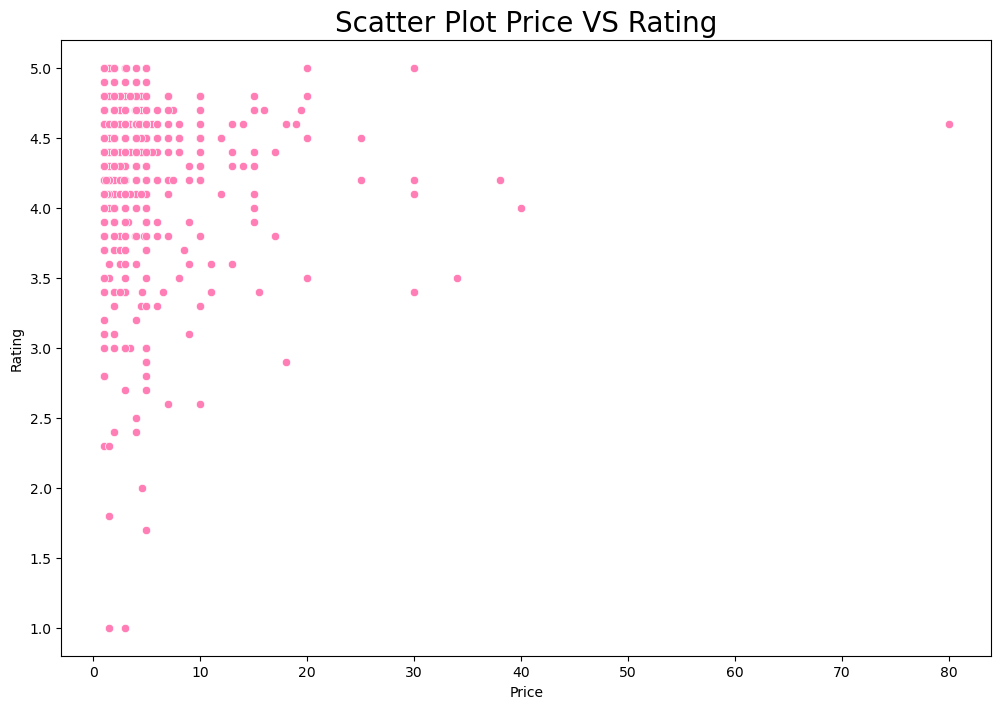

In [78]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=Paid_data, x='Price', y='Rating', color=Light_Categorical_Colors[3])
plt.title('Scatter Plot Price VS Rating', size=20 )
plt.show()

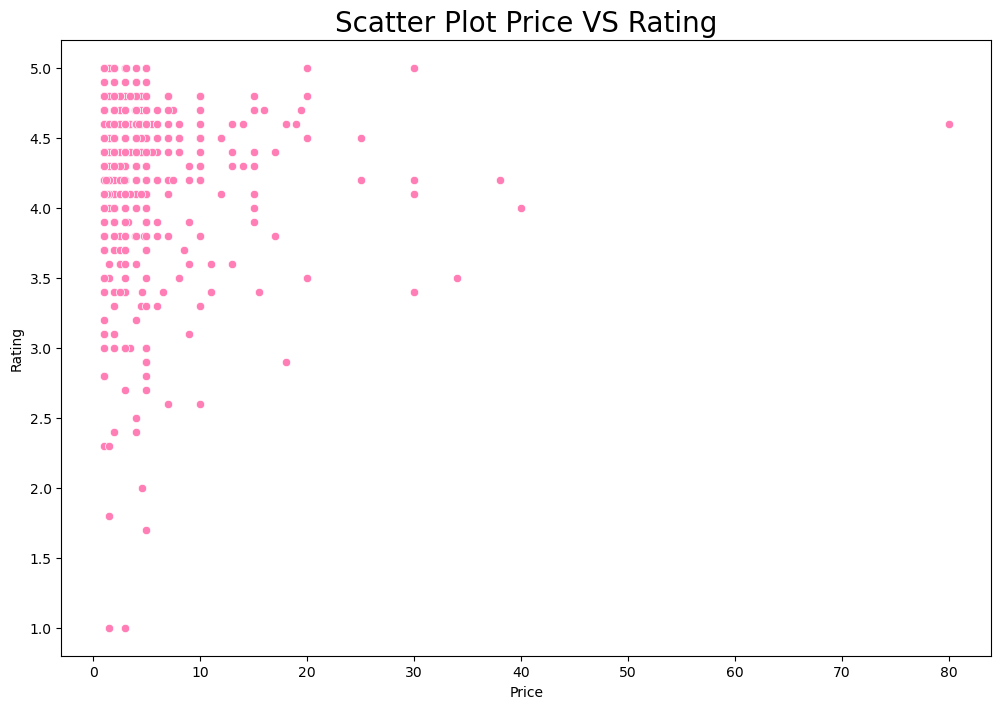

In [79]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=Paid_data, x='Price', y='Rating', color=Light_Categorical_Colors[3])
plt.title('Scatter Plot Price VS Rating', size=20 )
plt.show()

There is only 1 app with grater 50 price we will consider this as an outlier for better visualization.

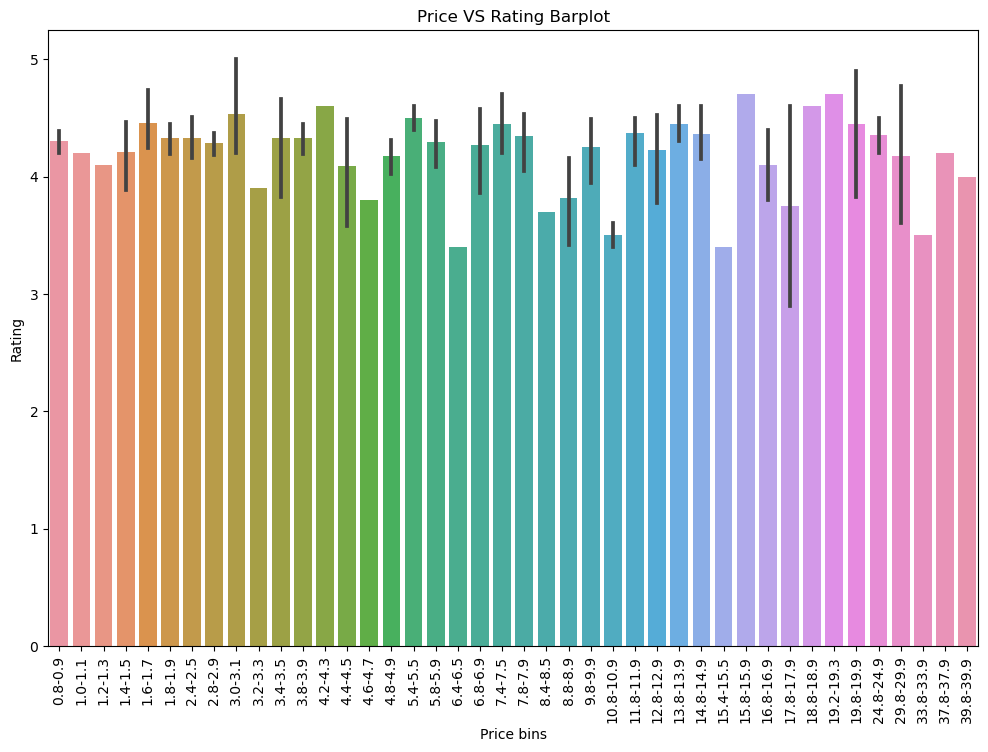

In [80]:
plt.figure(figsize=(12,8))
sns.barplot(data=clean_df[clean_df['Rating Category'] & (clean_df['Type'] == 'Paid') & (clean_df['Price'] <= 50)], x='Price bins', y='Rating', order= price_bins_order )
plt.xticks(rotation=90)
plt.title('Price VS Rating Barplot')
plt.show()

<AxesSubplot:xlabel='Installs', ylabel='Price'>

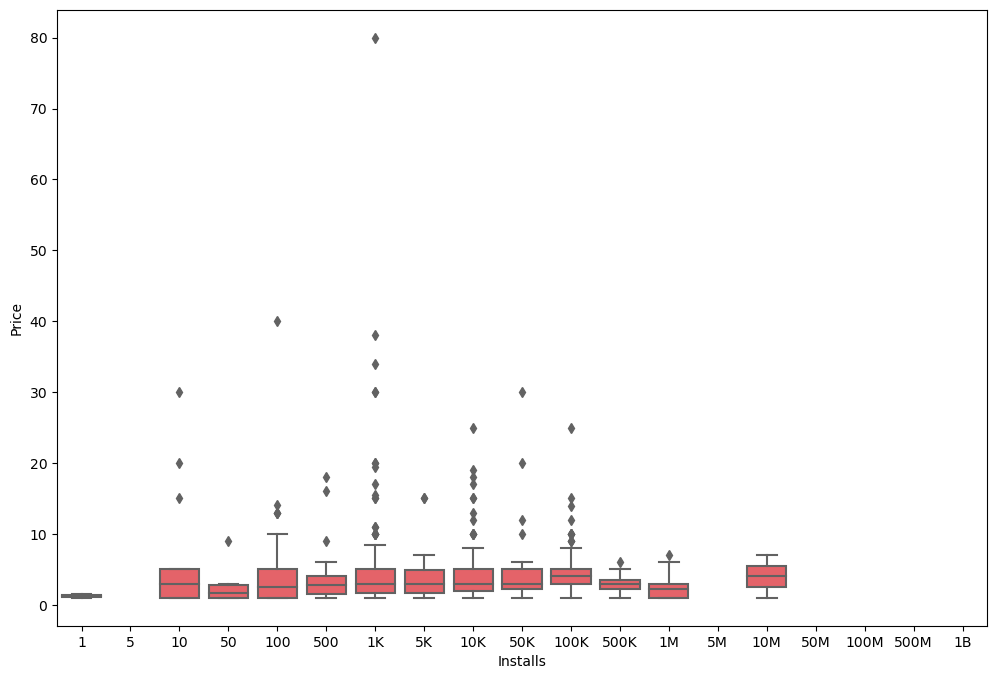

In [81]:
plt.figure(figsize=(12,8))
sns.boxplot(data=Paid_data, x='Installs', y='Price', color=Light_Categorical_Colors[4], order=Installs_order)

<AxesSubplot:xlabel='Rating', ylabel='Price'>

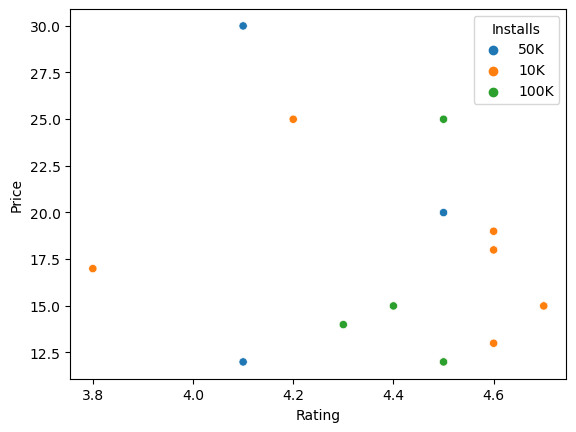

In [82]:
sns.scatterplot(data=Paid_data[(Paid_data['Price'] > 10) & Paid_data['Installs'].isin(['10K', '50K', '100K', '500K', '1M', '10M']) ], x='Rating', y='Price', hue='Installs')

### Observation
No paid app with 50M or more installs, an app with price higher than 10$ will definitely have less installs, unless the app has really high rating.